In [1]:
# !pip install keras-tcn --no-dependencies 
# !pip install tensorflow
# !pip install keras

In [1]:
# import key libraries to generate TCN
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Dense, Dropout, Embedding
from tensorflow.keras.preprocessing import sequence
import random

import pandas as pd
import numpy as np
import random

import ast
import matplotlib as plt
import time

from tcn import TCN

random.seed(42)

In [5]:
# importing data
df               = pd.read_csv(f'../data/industry-1/input_sequences_i.csv', index_col=0)
df['Flow']       = df['Sequence'].apply(ast.literal_eval)

flow_context       = df[['Flow', 'Context']]
lists_with_context = [(row['Flow'], row['Context']) for _, row in flow_context.iterrows()]

In [6]:
df['Flow'].iloc[20]

['WORKDAY_DB.DBO.T_EXCEPTION_PRC',
 'WORKDAY_DB.DBO.T_PREMASTER_PRC',
 'WORKDAY_DB.DBO.T_OVERRIDE_SEC_DERIV_FI',
 'WORKDAY_DB.DBO.T_OVERRIDE_APPROVE_SEC_IDENTIFIER',
 'WORKDAY_DB.DBO.T_FULL_SEC_OUT_STORE',
 'WORKDAY_DB.DBO.T_BPS_PRC',
 'WORKDAY_DB.DBO.T_OVERRIDE_APPROVE_SEC',
 'WORKDAY_DB.DBO.T_MASTER_SEC_IDENTIFIER',
 'WORKDAY_DB.DBO.T_PK_OVERRIDE_SEC',
 'WORKDAY_DB.DBO.TMP_T_OVERRIDE_SEC_DERIV_FI',
 'WORKDAY_DB.DBO.BCK_T_OVERRIDE_SEC_DERIV_FI_20221201',
 'WORKDAY_DB.DBO.T_MASTER_PRC',
 'WORKDAY_DB.DBO.T_MASTER_SEC_BCK23092022',
 'WORKDAY_DB.DBO.T_OVERRIDE_PRC',
 'WORKDAY_DB.DBO.T_OVERRIDE_APPROVE_SEC_DERIV_FI',
 'WORKDAY_DB.DBO.T_MASTER_SEC',
 'WORKDAY_DB.DBO.T_EXCEPTION_SEC',
 'WORKDAY_DB.DBO.BCK_T_OVERRIDE_APPROVE_SEC_DERIV_FI_20221201',
 'WORKDAY_DB.DBO.T_MASTER_PRC_AUDIT']

In [7]:
# Tokenization of data values
tokenize_dict         = {'pad': 0, 
                         'eos': 1}

reverse_tokenize_dict = {0: 'pad', 
                         1: 'eos'}

max_len       = 0

for flow, context in lists_with_context:
    
    if context not in tokenize_dict.keys():
        tokenize_dict[context] = len(tokenize_dict)
        reverse_tokenize_dict[len(reverse_tokenize_dict)] = context
        
        
    for element in flow:
        if (element, context) not in tokenize_dict.keys():
            tokenize_dict[(element, context)] = len(tokenize_dict)
            reverse_tokenize_dict[len(reverse_tokenize_dict)] = (element, context)
    
    if len(flow) > max_len:
        max_len = len(flow)

feature_length = len(tokenize_dict)
print(feature_length, max_len)

# To numerical and N-gram
context_window      = 8
numerical_sequences = []
input_sequences     = []

for flow, context in lists_with_context:
    
    seq = [tokenize_dict[context]]
    for element in flow: 
        seq.append(tokenize_dict[(element, context)])
    
    seq.append(tokenize_dict['eos'])
    numerical_sequences.append(seq)

170 37


In [8]:
for line in numerical_sequences:
    # Introduce padding
    newline = (context_window-2)*[0] + line
    
    for i in range(context_window, len(newline)):
        n_gram_sequence = newline[i-context_window:i]
        if len(n_gram_sequence) == context_window:
            input_sequences.append(n_gram_sequence)         

In [9]:
# Padding to ensure sequences are equal length
X                   = np.array([seq[:-1] for seq in input_sequences])
y                   = np.array([seq[-1] for seq in input_sequences])

msk                 = np.random.rand(len(X)) < 0.8

# Generate training and validation data
X_train, y_train    = X[msk], y[msk]
X_test, y_test      = X[~msk], y[~msk]

In [10]:
# TCN parameters
n_epochs       = 10
batch_size     = 4
embedding_size = 16

# Generate TCN architecture and model
tcn = TCN(
        nb_filters=8,
        kernel_size=2,
        dilations=(1, 2, 4),
        use_skip_connections=True,
        use_layer_norm=True
)

model = Sequential(layers=[
    Embedding(feature_length, embedding_size, mask_zero=True),
    Dropout(rate=0.3),
    tcn,
    Dense(feature_length, activation='softmax')
])

In [11]:
# Compile and train mode
model.summary()
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
r = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    epochs=n_epochs
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ tcn (TCN)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10



C:\Users\joel\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:934: UserWarning: Layer 'tcn' (of type TCN) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\joel\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:934: UserWarning: Layer 'conv1D_0' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\joel\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:934: UserWarning: Layer 'matching_conv1D' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
 

10212/10212 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.3508 - loss: 2.9386 - val_accuracy: 0.7291 - val_loss: 0.9472
Epoch 2/10
10212/10212 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.7268 - loss: 0.9361 - val_accuracy: 0.7616 - val_loss: 0.7663
Epoch 3/10
10212/10212 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.7492 - loss: 0.7909 - val_accuracy: 0.7832 - val_loss: 0.7000
Epoch 4/10
10212/10212 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.7589 - loss: 0.7480 - val_accuracy: 0.7705 - val_loss: 0.6642
Epoch 5/10
10212/10212 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.7677 - loss: 0.7055 - val_accuracy: 0.7960 - val_loss: 0.6224
Epoch 6/10
10212/10212 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.7711 - loss: 0.6900 - val_accuracy: 0.8048 - val_loss: 0.6209
Epoch 7/10
10212/10212 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.7741 - loss: 0.6712 - val_accuracy: 0.8032 - val_loss: 0.5882
Epoch 8/10
10212/10212 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.7830 - lo

In [12]:
# Predict best sequence based on earlier sequences
def pre_padding(context, tokenizer=tokenize_dict, context_window=context_window):
    # Conducts pre-padding on context
    context_values = [tokenizer[c] for c in context]
    padded_context = np.array([0] * (context_window - len(context_values) - 1) + context_values)
    
    return padded_context.reshape((1, len(padded_context)))

def process_identification(padded_context,
                           reverse_tokenizer=reverse_tokenize_dict, 
                           model=model):
    # Conducts pre-padding on context
    # Iteratively find the most probable next step based on model
    context_value   = padded_context[:, -1][0]
    context         = reverse_tokenizer[context_value]
    processes       = [k for k, v in reverse_tokenizer.items() if (context in v) & (k != context_value)]
    
    process_vlist   = [context_value]
    process_klist   = [context]

    while len(processes) > 0:
        maxv, maxp      = 0, None
        
        preds           = model.predict(padded_context)[0]

        for process in processes:
            if preds[process] >= maxv:
                maxv = preds[process]
                maxp = process
        
        # Remove models selected before (no cycles)
        processes.remove(maxp)
        process_vlist.append(maxp)
        process_klist.append(reverse_tokenizer[maxp])
        
        padded_context = pre_padding(process_klist)
        
    return [reverse_tokenizer[c] for c in padded_context[0] if c > 0][1:]

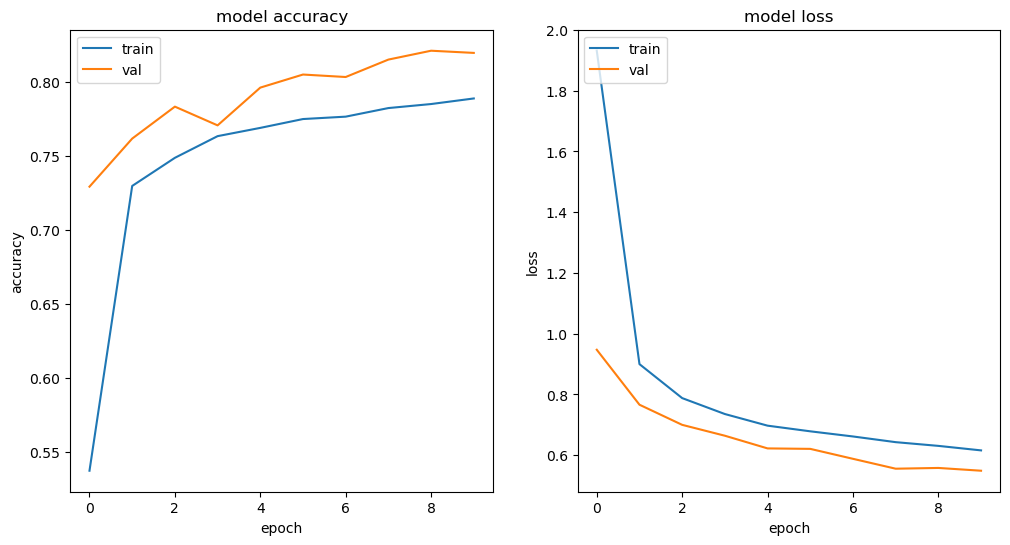

In [13]:
import matplotlib.pyplot as plt

# Plot model accuracy and loss across epochs
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(122)
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.show()

In [17]:
df.iloc[20]

Sequence    ['EDM_DB.DBO.T_EXCEPTION_PRC', 'EDM_DB.DBO.T_P...
Context                                      Zero Price Value
Flow        [EDM_DB.DBO.T_EXCEPTION_PRC, EDM_DB.DBO.T_PREM...
Name: 434282, dtype: object

In [43]:
pre_padding(['Zero Price Value', ('EDM_DB.DBO.T_EXCEPTION_PRC', 'Zero Price Value')]

array([[ 0,  0,  0,  0,  0, 67, 68]])